# Phase II: Data Curation, Exploratory Analysis and Plotting (5\%)

### Team Members:
- Rohita Nookala
- Mihika Chalasani
- Noura Alami
- Massa Alhajjiri


## Part 1:
(1%) Expresses the central motivation of the project and explains the (at least) two key questions to be explored. Gives a summary of the data processing pipeline so a technical expert can easily follow along.

## Problem Motivation
The film industry is one of the most influential and competitive sectors of the entertainment industry, with thousands of movies released per year. However, only a few movies are able to reach a certain level of popularity and success. By understanding what makes a movie popular and successful, studios and filmmakers can make more informed creative and marketing decisions.

We're analazying data obtained through the TMBI API, which provides detailed movie information, such as, rating, budget, popularity scores, and genres. By analyzing these different factors, it can show us patterns that explain why some movies do better than others. This analysis will focus on identifying which characteristics are most correlated with popularity and exploring how factors like genre and release date contribute to audience engagement. Additionally, we plan to build a simple predictive model to estimate a movie's popularity score based on key features. This could help highlight what kind of films are most likely to succeed in today's entertainment industry.



##Key Questions

1) Which features, such as genre, budget, or runtime,  have the strongest correlation with movie popularity?

2) Do certain genres tend to be more popular than others?

3) Can we predict a movie’s popularity based on these features?

Sources:

TMBI API. “The Movie Database API Documentation.” https://www.themoviedb.org/documentation/api


# Summary of the Data Processing Pipeline

1. Load movie data from the TMDB API
2. Clean and prepare the dataset for analysis
3. Build new variables to extract meaningful patterns
4. Visualize relationships using Seaborn, Matplotlib, and Plotly

To process the data, we'll start by pulling the movie information from TMDB API. This gives us variables like budget, runtime, genre, ratings, release data, and popularity scores. The cleaning process involves dealing with missing values in key columns, removing duplicate entries, and cutting out movies that do not meet the variable requirements. We'll also standardize the formatting of the data, an example of this would be using DateTime format for release dates and making sure all variables are typed out correctly.

Next, we'll modify and expand our dataset to answer our key questions. We'll extract the release year from dates to analyze trends over time. We might also calculate new metrics like budget-to-rating ratios to see if more spending actually does lead to more popularity.

Once the data is cleaned, we'll do exploratory analysis to find patterns. This means building correlation matrices to see which features relate to success, creating distribution plots to understand the range of budgets and ratings, and breaking down statistics by genre and year.

For visualization, we'll use different types of charts, such as scatter plots and box plots. Finally, we'll use the cleaned dataset for predictive regression techniques to estimate popularity scores based on the features that matter most. This should reveal which characteristics are the strongest predictors of movie success.

In [2]:
# Import needed libraries
import requests
import pandas as pd
import numpy as np
from datetime import datetime

# Base URL for TMDb API
secret = '843c1e5903cc736e05931bc0cb7f8adb'
base_url = "https://api.themoviedb.org/3"

# Get genre mapping
genre_endpoint = f"{base_url}/genre/movie/list?api_key={secret}&language=en-US"
genre_data = requests.get(genre_endpoint).json()
genre_dict = {g['id']: g['name'] for g in genre_data['genres']}

# Dictionary to store movie info
movie_dict = {
    'movie_id': [],
    'title': [],
    'release_date': [],
    'popularity': [],
    'vote_average': [],
    'vote_count': [],
    'genre_names': [],
    'budget': [],
    'revenue': [],
    'runtime': []
}

# Get popular movies and their detailed info
print("Getting movie data...")
for page in range(1, 6):
    url = f"{base_url}/movie/popular?api_key={secret}&language=en-US&page={page}"
    response = requests.get(url).json()
    
    for movie in response['results']:
        movie_id = movie.get('id')
        
        # Get movie info including budget and runtime
        detail_url = f"{base_url}/movie/{movie_id}?api_key={secret}&language=en-US"
        detail_response = requests.get(detail_url).json()
        
        movie_dict['movie_id'].append(movie_id)
        movie_dict['title'].append(movie.get('title'))
        movie_dict['release_date'].append(movie.get('release_date'))
        movie_dict['popularity'].append(movie.get('popularity'))
        movie_dict['vote_average'].append(movie.get('vote_average'))
        movie_dict['vote_count'].append(movie.get('vote_count'))
        
        # Convert genre IDs to genre names
        genres = movie.get('genre_ids', [])
        genre_names = [genre_dict[i] for i in genres if i in genre_dict]
        movie_dict['genre_names'].append(genre_names)
        
        # Add other information
        movie_dict['budget'].append(detail_response.get('budget', 0))
        movie_dict['revenue'].append(detail_response.get('revenue', 0))
        movie_dict['runtime'].append(detail_response.get('runtime'))

print("Creating DataFrame...")
movie_df = pd.DataFrame(movie_dict)

# Data Cleaning!
print("\nData Cleaning")
print(f"Original dataset size: {len(movie_df)} movies")

# Convert release_date to datetime
movie_df['release_date'] = pd.to_datetime(movie_df['release_date'], errors='coerce')

# Removing any missing data
movie_df = movie_df.dropna(subset=['release_date', 'vote_average', 'popularity'])
movie_df = movie_df[movie_df['budget'] > 0]
movie_df = movie_df[movie_df['runtime'] > 0]

# Remove duplicates based on movie_id
movie_df = movie_df.drop_duplicates(subset=['movie_id'])

print(f"After cleaning: {len(movie_df)} movies")
print(f"Missing values:\n{movie_df.isnull().sum()}")

print("\nBuilding New Variables")

# Get release year
movie_df['release_year'] = movie_df['release_date'].dt.year

# Calculating new values
movie_df['budget_per_rating'] = movie_df['budget'] / movie_df['vote_average']
movie_df['roi'] = ((movie_df['revenue'] - movie_df['budget']) / movie_df['budget']) * 100
movie_df['profitable'] = movie_df['revenue'] > movie_df['budget']
movie_df['popularity_per_vote'] = movie_df['popularity'] / movie_df['vote_count']

# Categorize budget into ranges
movie_df['budget_category'] = pd.cut(
    movie_df['budget'], 
    bins=[0, 10_000_000, 50_000_000, 100_000_000, float('inf')],
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Get primary genre (first in the list)
movie_df['primary_genre'] = movie_df['genre_names'].apply(
    lambda x: x[0] if len(x) > 0 else 'Unknown'
)

# Genre count per movie
movie_df['genre_count'] = movie_df['genre_names'].apply(len)

print("\nNew variables created:")
print("- release_year")
print("- budget_per_rating")
print("- roi (Return on Investment)")
print("- profitable (boolean)")
print("- popularity_per_vote")
print("- budget_category")
print("- primary_genre")
print("- genre_count")

# Display summary statistics
print("\nSummary Statistics")
print(movie_df[['budget', 'revenue', 'vote_average', 'popularity', 'roi']].describe())

# Display first few rows
print("\nSample Data")
print(movie_df.head())

# Save cleaned data
movie_df.to_csv('cleaned_movie_data.csv', index=False)
print("\nCleaned data saved to 'cleaned_movie_data.csv'")

Getting movie data...
Creating DataFrame...

Data Cleaning
Original dataset size: 100 movies
After cleaning: 54 movies
Missing values:
movie_id        0
title           0
release_date    0
popularity      0
vote_average    0
vote_count      0
genre_names     0
budget          0
revenue         0
runtime         0
dtype: int64

Building New Variables

New variables created:
- release_year
- budget_per_rating
- roi (Return on Investment)
- profitable (boolean)
- popularity_per_vote
- budget_category
- primary_genre
- genre_count

Summary Statistics
             budget       revenue  vote_average  popularity          roi
count  5.400000e+01  5.400000e+01     54.000000   54.000000    54.000000
mean   7.443761e+07  2.889029e+08      6.965407   94.284776   322.436658
std    8.253405e+07  4.357160e+08      0.984702   66.809302   710.644496
min    3.000000e+00  0.000000e+00      2.125000   38.836500  -100.000000
25%    1.753675e+07  2.204651e+06      6.580500   50.498525   -81.400204
50%    4.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

NameError: name 'genre_order' is not defined

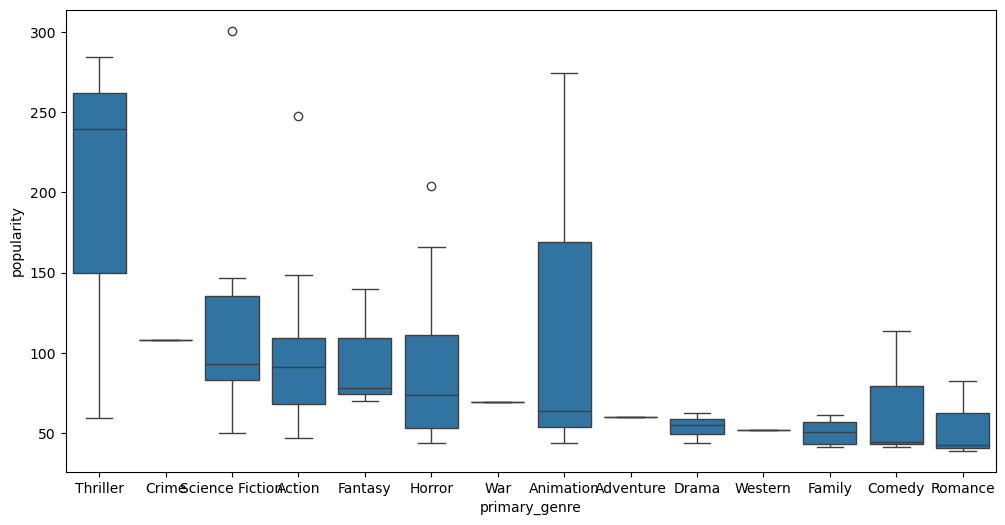

In [4]:
plt.figure(figsize=(12,6))

popular_order = movie_df.groupby('primary_genre')['popularity'].median().sort_values(ascending=False).index
sns.boxplot(
    data=movie_df, 
    x='primary_genre', 
    y='popularity', 
    order=popular_order,  
)


sns.stripplot(
    data=movie_df, 
    x='primary_genre', 
    y='popularity', 
    order=genre_order, 
    color='black', 
    size=4
)

plt.title("Movie Popularity by Primary Genre", fontsize=14)
plt.xlabel("Primary Genre")
plt.ylabel("Popularity")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

This boxplot shows how popularity differs across movie genres.  
We can see that Thriller and Animation genres generally have the highest median popularity, while Drama and Romance seem to be the lowest.  
The spread of points within each box indicates how varied popularity can be within the same genre. For example, thrillers have both very popular and less popular movies.  
This suggests that genre does influence a movie’s success, but it’s not the only factor.

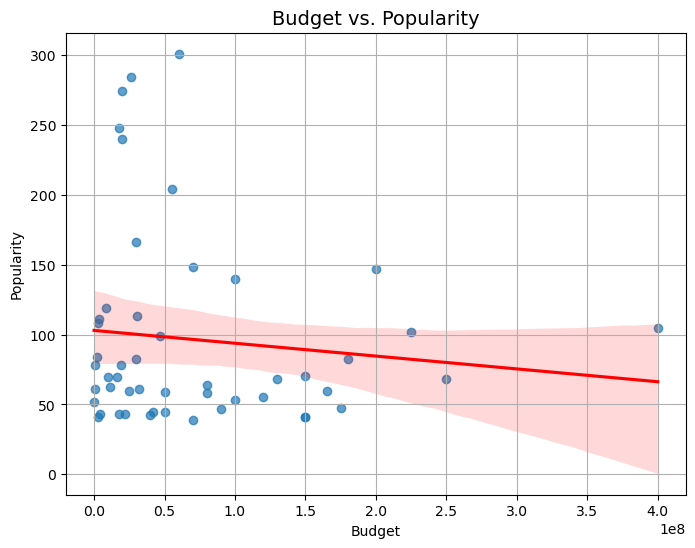

In [6]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=movie_df, 
    x='budget', 
    y='popularity', 
    scatter_kws={'alpha':0.7}, 
    line_kws={'color':'red'}
)
plt.title("Budget vs. Popularity", fontsize=14)
plt.xlabel("Budget")
plt.ylabel("Popularity")
plt.grid(alpha=1)
plt.show()

The scatterplot compares movie budgets with their popularity scores.  
The red regression line is slightly downward-sloping, meaning there is no strong positive relationship between a higher budget and greater popularity.  
This implies that spending more money on production doesn’t necessarily make a movie more popular. 

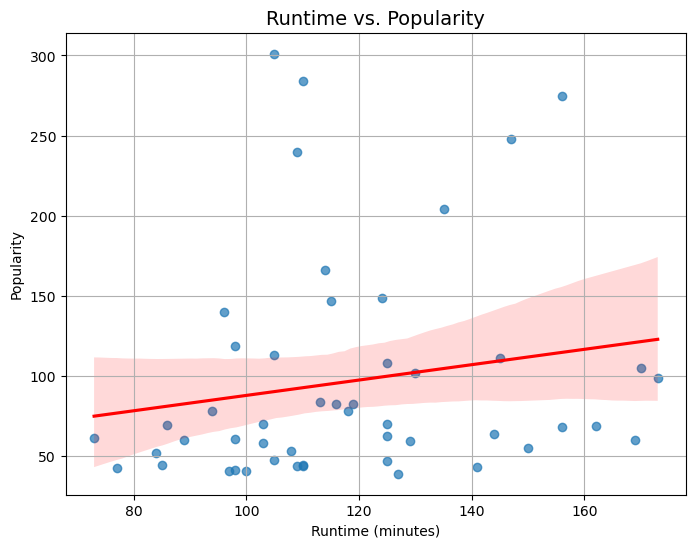

In [7]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=movie_df, 
    x='runtime', 
    y='popularity',
    scatter_kws={'alpha':0.7}, 
    line_kws={'color':'red'}
)
plt.title("Runtime vs. Popularity", fontsize=14)
plt.xlabel("Runtime (minutes)")
plt.ylabel("Popularity")
plt.grid(alpha=1)
plt.show()

This plot explores how a movie’s runtime relates to its popularity.  
There’s a small upward trend, showing that longer movies may be slightly more popular, but the correlation is weak.  
This means runtime alone doesn’t determine how well a movie performs.

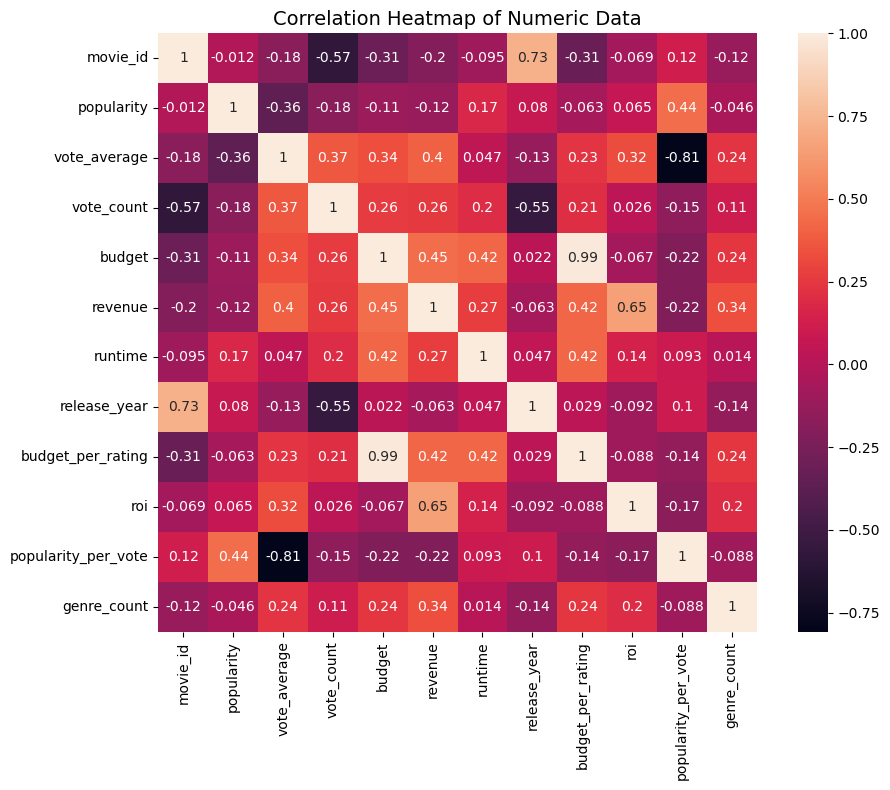

In [8]:
plt.figure(figsize=(10,8))
numeric_df = movie_df.select_dtypes(include=[np.number])
corr_df = numeric_df.corr()

sns.heatmap(corr_df, annot=True, square=True)
plt.title("Correlation Heatmap of Numeric Data", fontsize=14)
plt.tight_layout()
plt.show()

The heatmap visualizes how different numeric variables in the dataset relate to one another. Overall, financial features seem to show the strongest connections. For example, budget and revenue have a moderate positive correlation of about 0.52, indicating that movies with larger production budgets tend to earn higher revenue, though not always proportionally. On the other hand, revenue and ROI share a moderate correlation  (0.61), suggesting that while profitable movies often have higher returns, the relationship isn’t linear. But, audience related factors behave differently: popularity and vote average are negatively correlated (-0.37), showing that critically high-rated films are not necessarily the most popular, whereas popularity and popularity per vote (0.46) reveal that strong audience engagement tends to drive popularity. Other factors like runtime or release year show weak or negligible correlations, implying that these characteristics have little direct impact on a movie’s overall success.
